# NLP & W2VEC

In [2]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER, word_tokenize # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load

In [3]:
data = pd.read_csv("./data/message_temp.csv")
data = data[['message', 'category']]

In [4]:
data.head()

,message,category
0,ขอบคุณค่ะ,C
1,โอเคค่ะ,C
2,ให้อาจารย์เซ็นเรียบร้อยแล้วครับ,T
3,ได้ค่ะ,C
4,โอเคครับ ผมขอเอาไปให้อาจารย์เซ็นก่อนครับ,T


### Thai Cleaning Data

In [6]:
def process_thai_text(text):
    text = text.lower().replace('\n', ' ').replace('\r', '').strip()
    text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
    text = ''.join(text)

    stop_words = common.thai_stopwords()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    text = ' '.join(filtered_sentence)
    return text

In [7]:
data['message_parsed'] = data['message'].apply(process_thai_text)

In [8]:
print(data['message_parsed'])

2                                 อาจารย์ เซ็น เรียบร้อย
4                               โอเค ครับผม อาจารย์ เซ็น
7      ขอโทษ ครับผม ลืม ถาม เรื่อง ลายเซ็น อาจารย์ที่...
10                                        พี่ ศุกร์ นะคะ
13                                          กรอก ใบสมัคร
                             ...                        
127             สวัสดิ์ ดี ครับผม อนุ ญาติ เอกสาร ฝึกงาน
129                       ผม สะดวก ตารางเวลา เต็ม ขออภัย
130                                ทำงาน ชม สัปดาห์ นะคะ
131    อันนี้ เวลาเรียน จันทร์ พุธ ศุกร์ เวลาทำงาน นอ...
133    พี่ ทาบทาม tafundamathematicsforengineer แม็ท ...
Name: message_parsed, Length: 73, dtype: object


### Data Features and Values

In [5]:
data['category'].unique()

array(['C', 'T', 'Q', 'S', 'A'], dtype=object)

In [9]:
# filter common chat
data = data.drop(data.index[ data['category'] == 'C' ])
# filter empty message
data = data[data['message_parsed'].str.strip().astype(bool)]
# sort data by category
data = data.sort_values(by=['category'])

data = data.reset_index()
data = data[['message', 'message_parsed', 'category']]

data.head()

,message,message_parsed,category
0,ตรงงานที่ทำ,งาน ทำ,A
1,ไม่ยังส่งเอกสาร เบิกเหมือนกัน,เอกสาร เบิก เหมือนกัน,A
2,ครั้งที่แล้วยังไม่ส่งเอกสารเบิกจ่ายหรือค่ะ,เอกสาร เบิก จ่าย,A
3,หนังสือรับรองเข้าฝึกงานจากบริษัทครับ,หนังสือรับรอง ฝึกงาน บริษัท,A
4,กรอกคำว่า ตรวจการบ้าน อย่างเดี่ยวเลยค่ะ,กรอก ตรวจ การบ้าน เดี่ยว,A


In [10]:
data.shape

(72, 3)

In [11]:
data.dtypes

message           object
message_parsed    object
category          object
dtype: object

In [12]:
data.isnull().any()

message           False
message_parsed    False
category          False
dtype: bool

### Countplot of target Variable(Category)

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

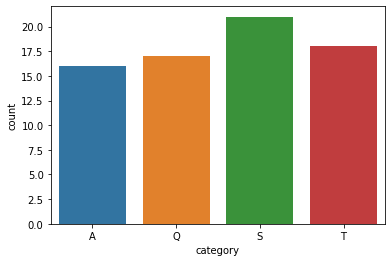

In [13]:
sns.countplot(data.category)

In [14]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0      11
1      29
2      42
3      36
4      39
     ... 
67     23
68     27
69     40
70     39
71    123
Name: message_length, Length: 72, dtype: int64


### Words Distribution Plot

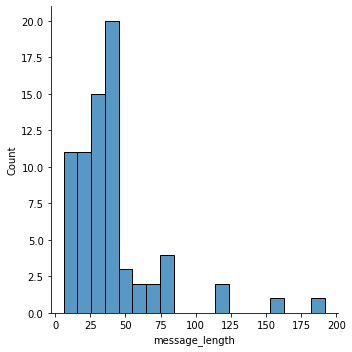

In [15]:
sns.displot(data['message_length']).set_titles('message_length')

### Word Cloud

In [16]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      stopwords = ' '.join(common.thai_stopwords()), # ลบคำที่ไม่ใช้ออก
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [17]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

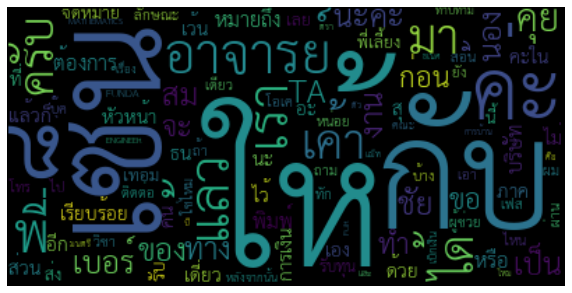

In [18]:
check_wordcloud('T')

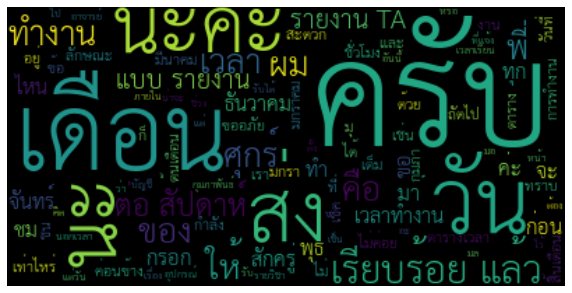

In [19]:
check_wordcloud('S')

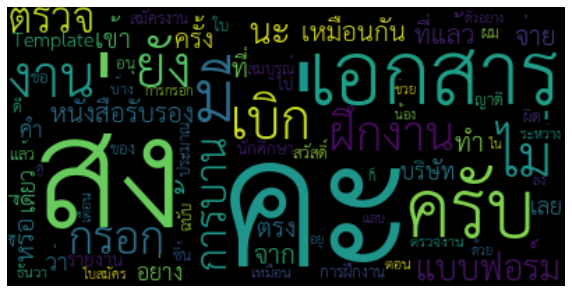

In [20]:
check_wordcloud('A')

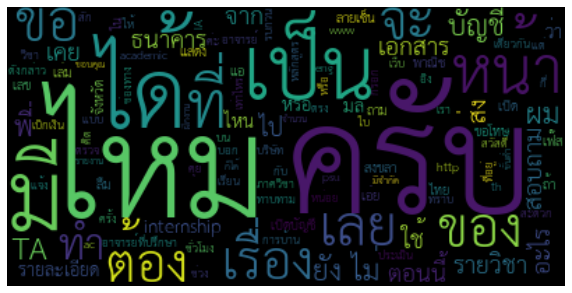

In [21]:
check_wordcloud('Q')

### Label Encoding

In [22]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [23]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

   category  category_target
0         A                0
16        Q                1
33        S                2
54        T                3


In [24]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [25]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [26]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'Q', 'category_target': 1}, {'category': 'S', 'category_target': 2}, {'category': 'T', 'category_target': 3}]


In [27]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'Q', 'S', 'T']


### Word2Vec

In [102]:
card_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(data.message_parsed)]

In [28]:
w2v_model = Doc2Vec(min_count=1, epochs=20)
w2v_thai = WordVector()

In [104]:
w2v_model.build_vocab(card_docs)

w2v_model.train(card_docs, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

In [29]:
# old method
# word2vec = [w2v_model.infer_vector((data['message_parsed'][i].split(' '))) 
#             for i in range(0,len(data['message_parsed']))]

# new method
word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [30]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
#old
# data_reshape = np.reshape(X, (-1, 100))
#new
data_reshape = np.reshape(X, (-1, 300))

In [31]:
print(data_reshape.shape)

(72, 300)


In [32]:
data.head()

,message,message_parsed,category,message_length,category_target,word2vec
0,ตรงงานที่ทำ,งาน ทำ,A,11,0,"[[0.18430849723517895, -0.26013100426644087, 0..."
1,ไม่ยังส่งเอกสาร เบิกเหมือนกัน,เอกสาร เบิก เหมือนกัน,A,29,0,"[[-0.08914485440722533, 0.17833656924111502, 0..."
2,ครั้งที่แล้วยังไม่ส่งเอกสารเบิกจ่ายหรือค่ะ,เอกสาร เบิก จ่าย,A,42,0,"[[-0.10494039803743363, -0.0019164031371474266..."
3,หนังสือรับรองเข้าฝึกงานจากบริษัทครับ,หนังสือรับรอง ฝึกงาน บริษัท,A,36,0,"[[0.07958716742966014, -0.09782449932148059, 0..."
4,กรอกคำว่า ตรวจการบ้าน อย่างเดี่ยวเลยค่ะ,กรอก ตรวจ การบ้าน เดี่ยว,A,39,0,"[[-0.016739728013900192, -0.10112627263350243,..."


### Saving Word2Vector Model

In [109]:
dump(w2v_model, './models/w2v_model.joblib')

['./models/w2v_model.joblib']

# AI MODEL

### Split the data in Training and Testing

In [34]:
data_temp = [ x for x in data['word2vec']]
#old
# data_reshape = np.reshape(data_temp, (-1, 100))
#new
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(72, 300)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    test_size = 0.2,
                                                    random_state=8,
                                                    )

In [131]:
print(X_train.shape)
print(y_train.shape)

(57, 100)
(57,)


In [113]:
print(X_test.shape)
print(y_test.shape)

(15, 100)
(15,)


### Models Predictions

In [38]:
# LinerRegression Model
l_model = LogisticRegression()
l_model.fit(X_train, y_train)
model_predictions = l_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.7333333333333333
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.75      0.75      0.75         4
           2       0.50      1.00      0.67         2
           3       1.00      0.83      0.91         6

    accuracy                           0.73        15
   macro avg       0.69      0.73      0.68        15
weighted avg       0.77      0.73      0.73        15



In [39]:
# Unsupervised Model
kn_model = KNeighborsClassifier(n_neighbors=1)
kn_model.fit(X_train, y_train)
model_predictions = kn_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.4666666666666667
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.25      0.33         4
           2       0.20      0.50      0.29         2
           3       0.67      0.67      0.67         6

    accuracy                           0.47        15
   macro avg       0.47      0.44      0.42        15
weighted avg       0.53      0.47      0.47        15



In [43]:
# RandomForest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.5333333333333333
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      1.00      0.67         4
           2       0.33      0.50      0.40         2
           3       1.00      0.33      0.50         6

    accuracy                           0.53        15
   macro avg       0.58      0.54      0.49        15
weighted avg       0.68      0.53      0.51        15



In [44]:
# GaussianNB Model
g_model = GaussianNB()
g_model.fit(X_train, y_train)
model_predictions = g_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       1.00      0.50      0.67         4
           2       0.50      1.00      0.67         2
           3       1.00      0.50      0.67         6

    accuracy                           0.60        15
   macro avg       0.71      0.67      0.61        15
weighted avg       0.80      0.60      0.62        15



### Save AI Model

In [45]:
dump(l_model, './models/l_model.joblib')

['./models/l_model.joblib']

In [74]:
dump(kn_model, './models/kn_model.joblib')

['./models/kn_model.joblib']

In [53]:
dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

In [61]:
dump(g_model, './models/g_model.joblib')

['./models/g_model.joblib']

### BayesSearch Hyperparameter Tunning

In [123]:
model = KNeighborsClassifier()
opt = BayesSearchCV(
    model,
    {
        'n_neighbors': Integer(1, 20),
        'p': Integer(1, 20)
    }
    , cv=3, verbose=1, n_jobs=1
)
opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

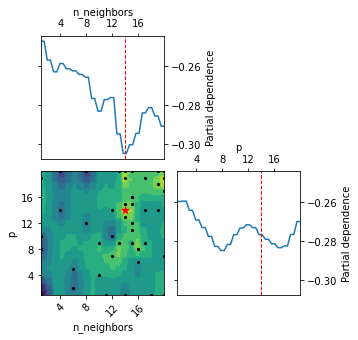

In [124]:
plot_objective(opt.optimizer_results_[0],
                   dimensions=['n_neighbors','p'],
                   n_minimum_search=int(1e8))
plt.show()

# Use Case

In [46]:
# load w2vector model and ai model
model = load('./models/l_model.joblib') 
w2v_model = load('./models/w2v_model.joblib')
w2v_thai = WordVector()

In [75]:
text_input = 'พรุ่งนี้มีนัดทำงานนะ'

In [51]:
# old
# processed_text = process_thai_text(text_input)

In [76]:
# old
# test_vec = w2v_model.infer_vector((processed_text.split(' ')))

# new
test_vec = w2v_thai.sentence_vectorizer(text_input)
test_vec.shape

(1, 300)

In [77]:
output = model.predict(test_vec)
output_classes = label_encoder.classes_
output_label = output_classes[output[0]]
output_label

'S'

# Use Case with Modules


In [2]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [5]:
# old
# message_classifier.load_model(model_path='./models/kn_model.joblib', w2v_path='./models/w2v_model.joblib', json_classes_path='./classes.json')
# new 
message_classifier.load_model(model_path='./models/l_model.joblib', json_classes_path='./classes.json')

In [6]:
print(message_classifier.classify(text_input='พรุ่งนี้มีการบ้านที่ต้องส่งอะไรบ้าง'))

Q
